In [1]:
import pandas as pd
import numpy as np
grid = pd.read_pickle("outputs_in_instab_strip.pkl")

# then we have to first create the X and y matrices.

l_values = [0, 1, 2] 
l_columns = {l: [col for col in grid.columns if col.endswith(f"_l_{l}")] for l in l_values}

X_frequencies = np.hstack([grid[l_columns[l]].values for l in l_values])  
delta_nu_values = grid["delta_nu"].values[:, np.newaxis] 
mod_frequencies = X_frequencies % delta_nu_values 

X = np.stack((X_frequencies, mod_frequencies), axis=-1)
y = np.hstack([np.full_like(grid[l_columns[l]].values, l) for l in l_values])  

print(f"X-matrix shape: {X.shape}")
print(f"y-matrix shape: {y.shape}") 

from sklearn.model_selection import train_test_split
import torch

# Convert data to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)  # Assuming y contains class labels

# Split the data (80% train, 10% val, 10% test)
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print shape
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

size = X_train.shape[0]
inpt = X_train[:size]
print(inpt.shape)

X-matrix shape: (153314, 30, 2)
y-matrix shape: (153314, 30)
Train: torch.Size([122651, 30, 2]), Validation: torch.Size([15331, 30, 2]), Test: torch.Size([15332, 30, 2])
torch.Size([122651, 30, 2])


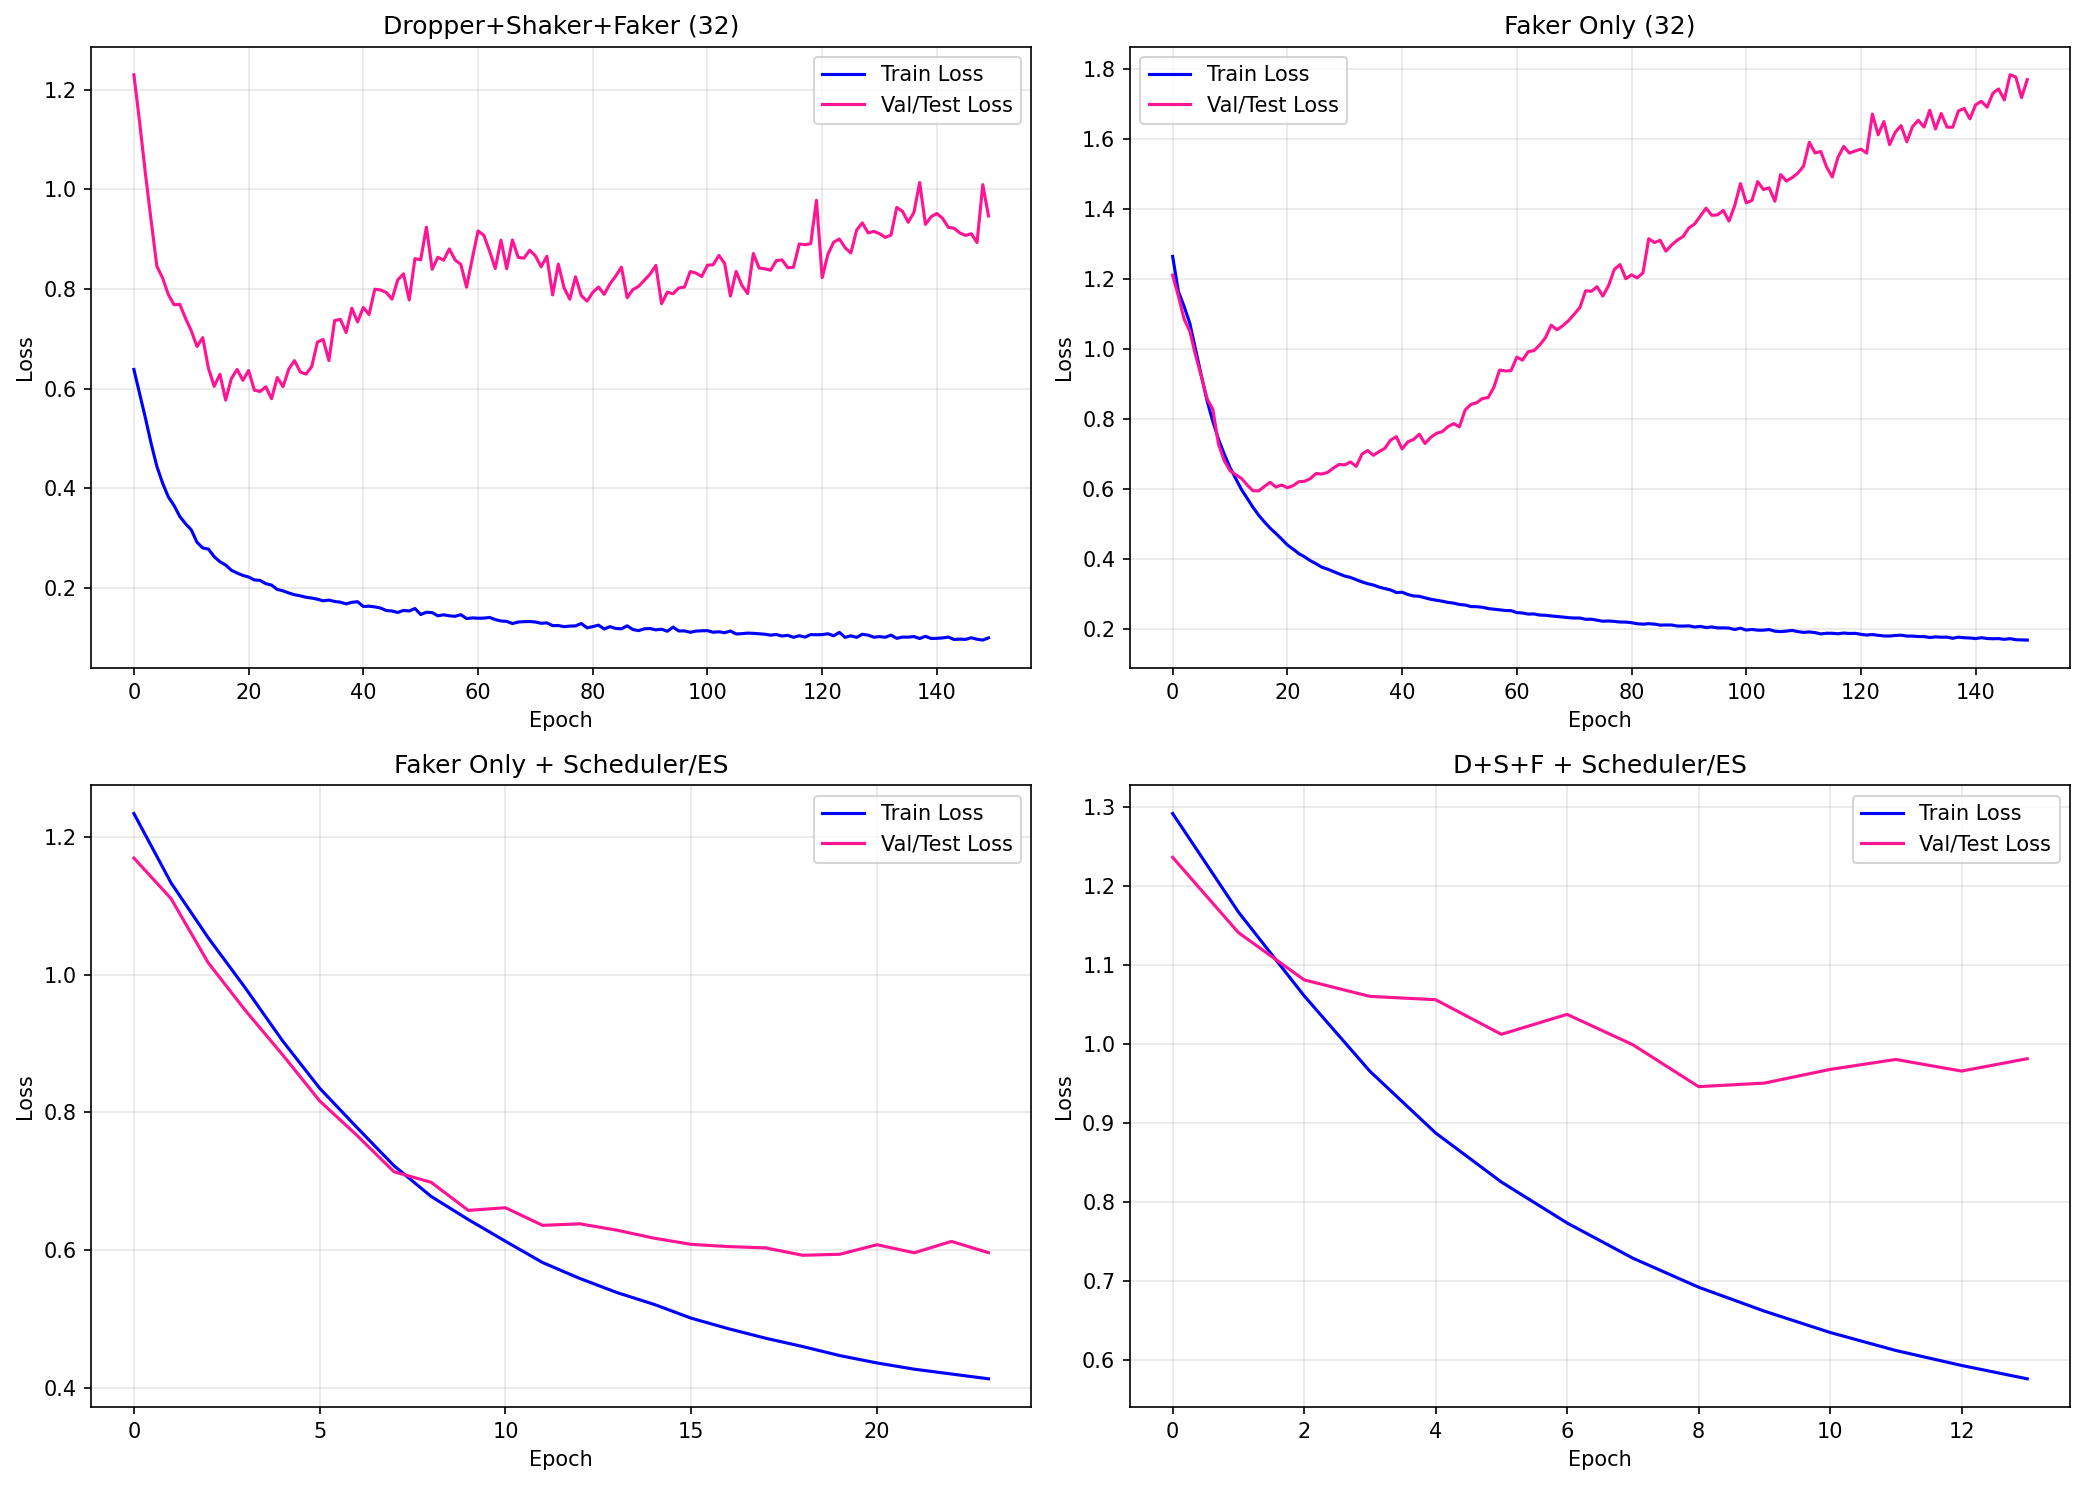

In [6]:
import matplotlib.pyplot as plt
import pickle
import os

# Define file-label mapping
file_info = {
    "dsf32layers": {
        "train": "train_history_dsf32layers.pkl",
        "test": "test_history_dsf32layers.pkl",
        "label": "Dropper+Shaker+Faker (32)"
    },
    "f32layers": {
        "train": "train_history_fake02.pkl",  # assumed correction
        "test": "test_history_fake02.pkl",    # assumed correction
        "label": "Faker Only (32)"
    },
    "newf02SchedulerEarlyStop": {
        "train": "train_history_newf02SchedulerEarlyStop.pkl",
        "test": "val_history_newf02SchedulerEarlyStop.pkl",
        "label": "Faker Only + Scheduler/ES"
    },
    "d05s05newf02SchedulerEarlyStop": {
        "train": "train_history_d05s05newf02SchedulerEarlyStop.pkl",
        "test": "val_history_d05s05newf02SchedulerEarlyStop.pkl",
        "label": "D+S+F + Scheduler/ES"
    }
}

# Load histories
histories = {}
for key, paths in file_info.items():
    with open(paths["train"], "rb") as f_train, open(paths["test"], "rb") as f_test:
        histories[key] = {
            "train": pickle.load(f_train),
            "test": pickle.load(f_test),
            "label": paths["label"]
        }

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=150)
axes = axes.flatten()

for idx, (key, data) in enumerate(histories.items()):
    ax = axes[idx]
    ax.plot(data["train"], label="Train Loss", color='blue')
    ax.plot(data["test"], label="Val/Test Loss", color='deeppink')
    ax.set_title(data["label"])
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

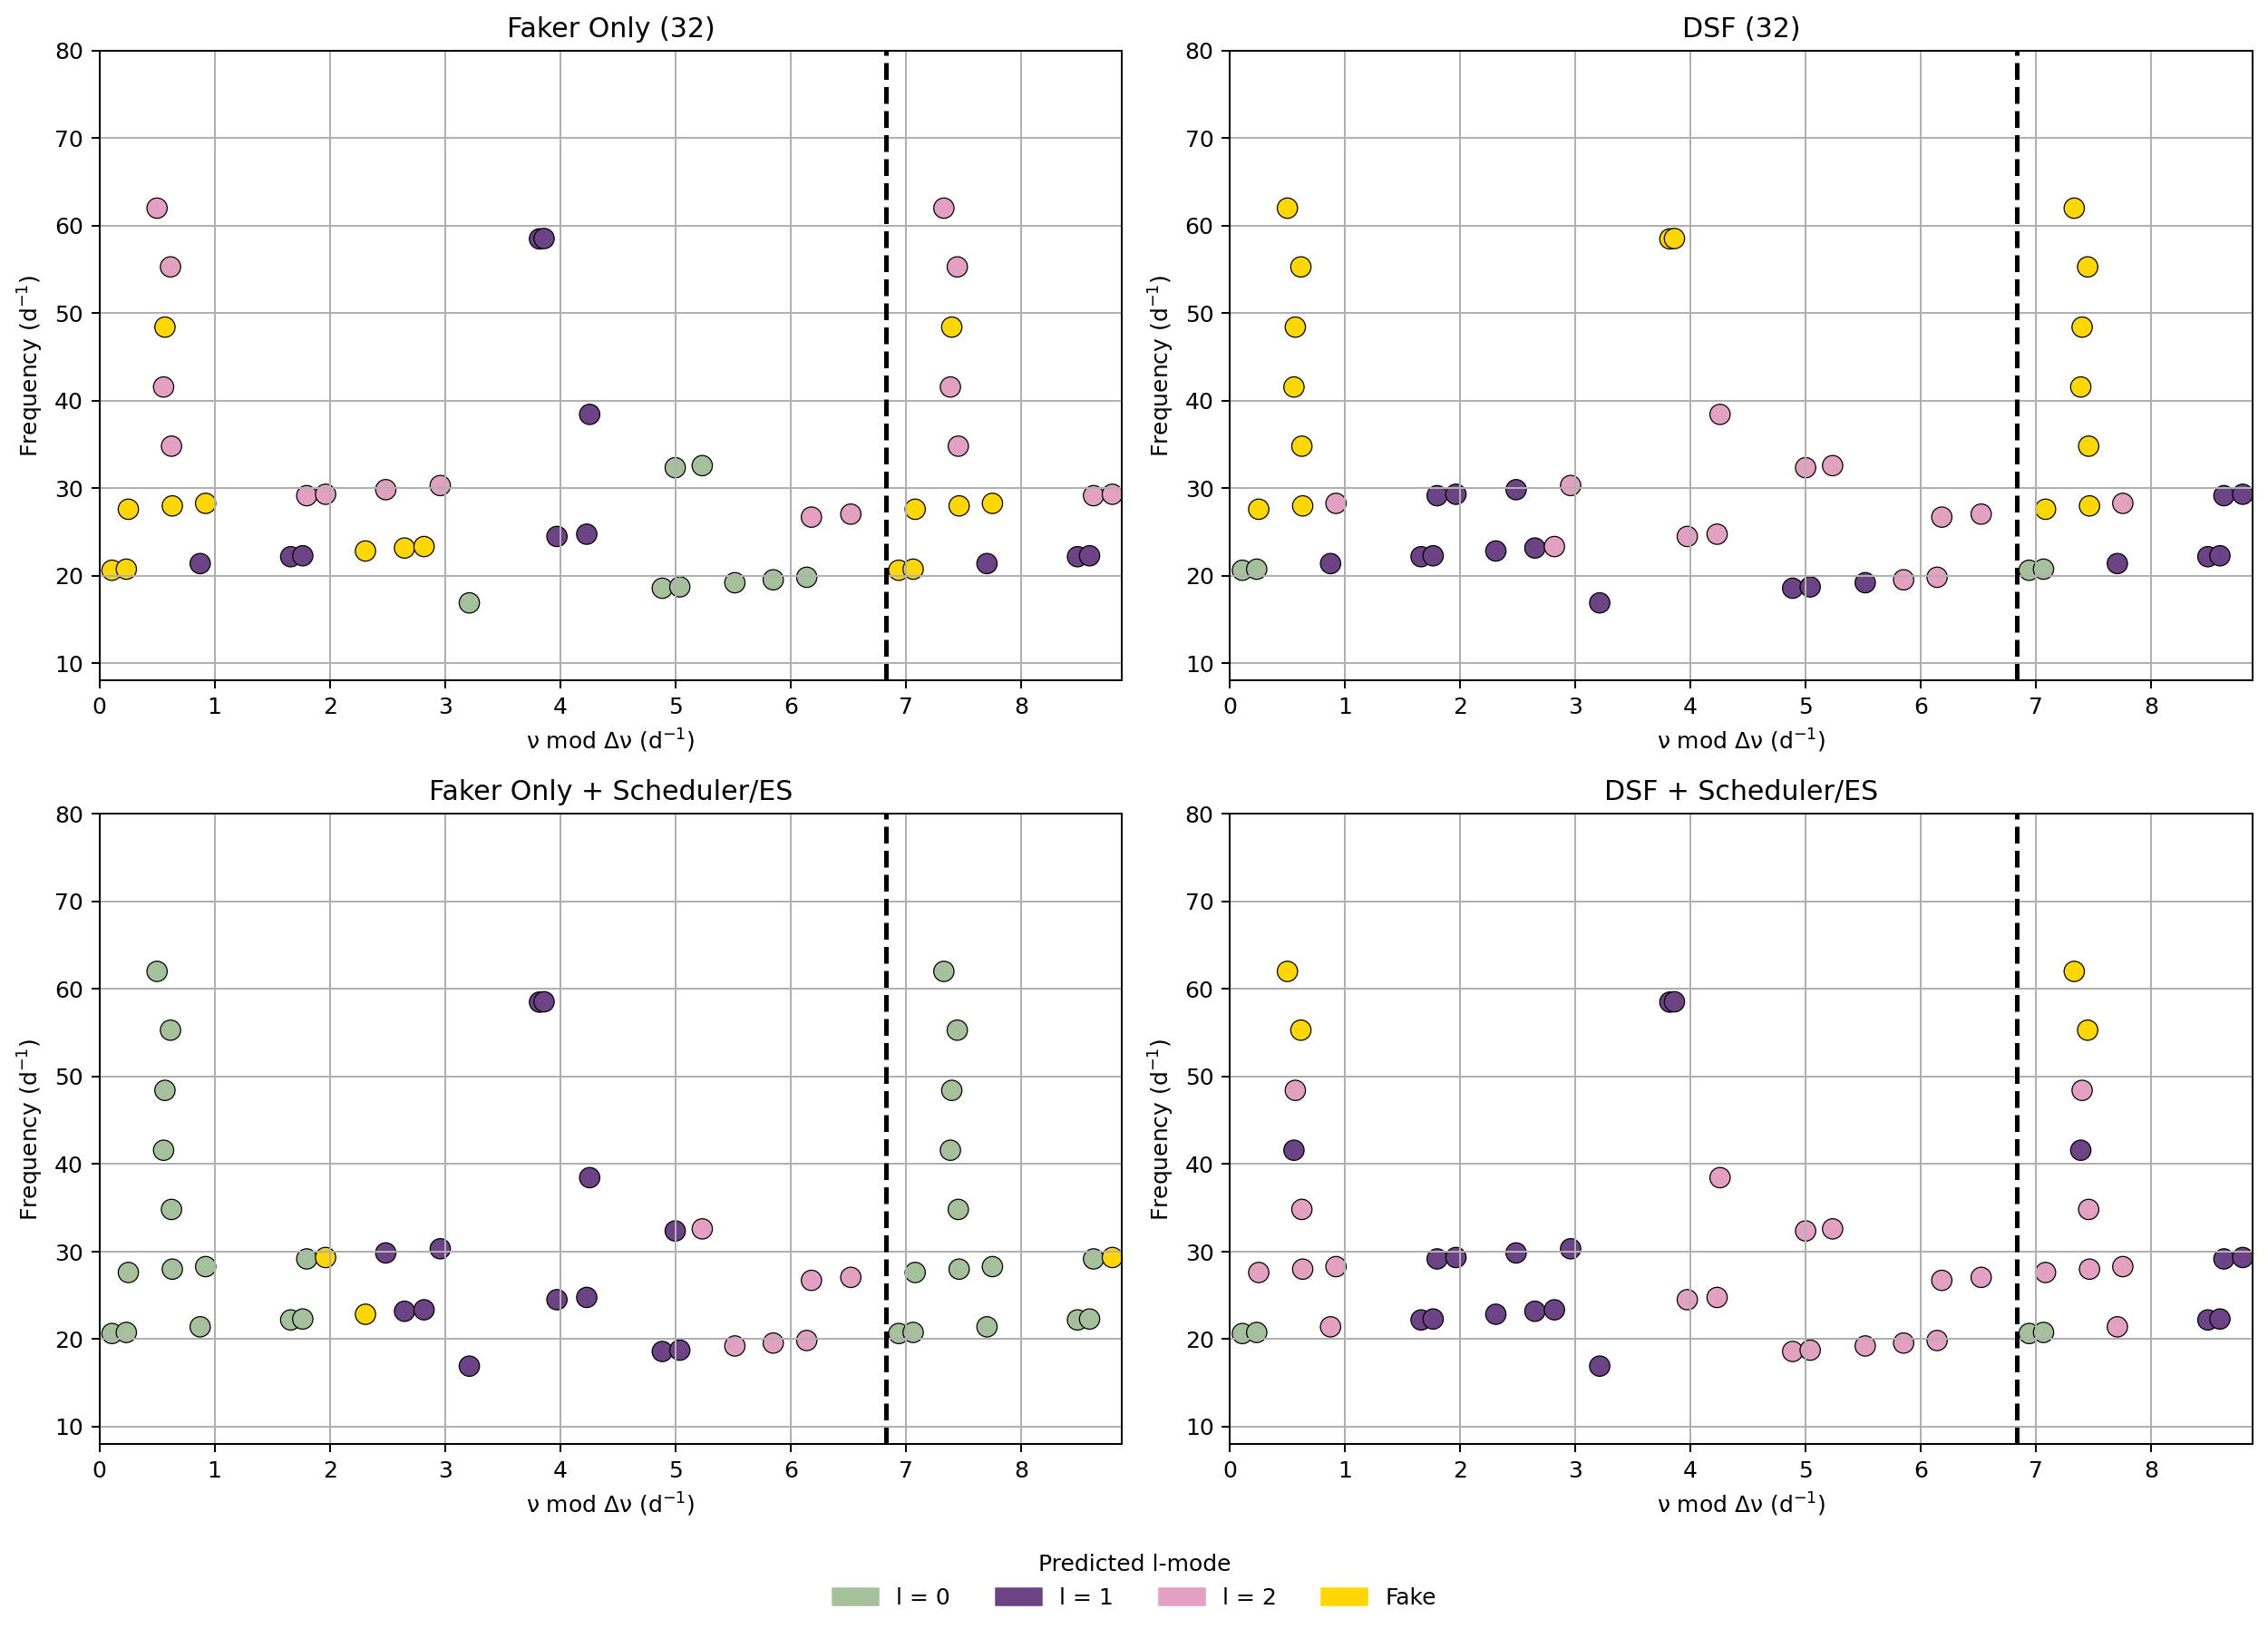

In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# --- Input frequencies ---
frequencies = np.array([
    21.36513, 27.95328, 34.77609, 41.53747, 48.37933, 55.25743, 61.97086,
    16.87165, 32.55347, 38.40601, 58.46084, 28.24243, 27.01307, 20.59936,
    18.54655, 18.69868, 19.17648, 19.50970, 19.80056, 20.72404, 22.15081,
    22.25558, 22.79990, 23.13894, 23.30843, 24.46210, 24.72073, 26.67124,
    27.57177, 29.12013, 29.28361, 29.80605, 30.27912, 32.31897, 58.50036
])

#below are only the identified ones
""" 
frequencies = np.array([
    21.36513, 27.95328, 34.77609, 41.53747, 48.37933, 55.25743, 61.97086,
    26.73244, 32.55347, 38.40601, 58.46084
])

"""
delta_nu = 6.83
nu_mod_delta_nu = np.mod(frequencies, delta_nu)
X_hd = torch.tensor(np.stack([frequencies, nu_mod_delta_nu], axis=1), dtype=torch.float32).unsqueeze(0)

# --- Model definition ---
class PointNet(torch.nn.Module):
    def __init__(self, num_classes=4, point_dimension=2, dropout=0.3):
        super(PointNet, self).__init__()
        a = 3
        nfeat = 64
        self.conv_1_a = torch.nn.Conv1d(1, nfeat, kernel_size=a, padding=1)
        self.conv_1_b = torch.nn.Conv1d(1, nfeat, kernel_size=a, padding=1)
        self.conv_2 = torch.nn.Conv1d(nfeat, nfeat, kernel_size=a)
        self.bn_1 = torch.nn.BatchNorm1d(nfeat)
        self.bn_2 = torch.nn.BatchNorm1d(nfeat)
    def forward(self, x):
        batch_size, num_points, _ = x.shape
        x_freq = x[:, :, 0].unsqueeze(1)
        x_modnu = x[:, :, 1].unsqueeze(1)
        x_freq = torch.nn.functional.pad(x_freq, (1, 1), mode='replicate')
        x_modnu = torch.nn.functional.pad(x_modnu, (1, 1), mode='circular')
        x = self.conv_1_a(x_freq) + self.conv_1_b(x_modnu)
        x = torch.nn.functional.relu(self.bn_1(x))
        x = torch.nn.functional.relu(self.bn_2(self.conv_2(x)))
        x = torch.nn.functional.max_pool1d(x, kernel_size=x.size(-1))
        return x.view(batch_size, -1)

class SegmentationPointNet(torch.nn.Module):
    def __init__(self, num_classes=4, point_dimension=2, dropout=0.3):
        super(SegmentationPointNet, self).__init__()
        self.base_pointnet = PointNet(num_classes=num_classes, point_dimension=point_dimension)
        nfeat = 64
        nhidden = 64
        self.fc_1 = torch.nn.Linear(nfeat + 2, nhidden)
        self.fc_2 = torch.nn.Linear(nhidden, num_classes)
    def forward(self, x):
        global_feat = self.base_pointnet(x).unsqueeze(1).repeat(1, x.shape[1], 1)
        x = torch.cat([x, global_feat], dim=2)
        x = torch.nn.functional.relu(self.fc_1(x))
        return torch.nn.functional.log_softmax(self.fc_2(x), dim=2)

# --- Model files and titles ---
model_files = {
    "segmentation_pointnet_f32layers.pth": "Faker Only (32)",
    "segmentation_pointnet_dsf32layers.pth": "DSF (32)",
    "segmentation_pointnet_newf02SchedulerEarlyStop.pth": "Faker Only + Scheduler/ES",
    "segmentation_pointnet_d05s05newf02SchedulerEarlyStop.pth": "DSF + Scheduler/ES"
}

# --- Color setup ---
color_map = {0: '#a5c19b', 1: '#6c4385', 2: '#e3a0c0', 3: 'gold'}
legend_elements = [
    mpatches.Patch(color=color_map[0], label='l = 0'),
    mpatches.Patch(color=color_map[1], label='l = 1'),
    mpatches.Patch(color=color_map[2], label='l = 2'),
    mpatches.Patch(color=color_map[3], label='Fake')
]

# --- Plot ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=180)
axes = axes.flatten()

for i, (model_file, title) in enumerate(model_files.items()):
    model = SegmentationPointNet()
    model.load_state_dict(torch.load(model_file, map_location=torch.device('cpu')))
    model.eval()

    with torch.no_grad():
        logits_hd = model(X_hd)
        probs_hd = torch.exp(logits_hd)[0].numpy()
        preds_hd = np.argmax(probs_hd, axis=1)

    colors_pred = [color_map[int(p)] for p in preds_hd]

    ax = axes[i]
    ax.scatter(nu_mod_delta_nu, frequencies, c=colors_pred, edgecolors='black', linewidths=0.5, s=80)
    ax.scatter(nu_mod_delta_nu + delta_nu, frequencies, c=colors_pred, edgecolors='black', linewidths=0.5, s=80)
    ax.axvline(delta_nu, color='black', linestyle='--', linewidth=2)
    ax.set_xlim(0, delta_nu * 1.3)
    ax.set_ylim(8, 80)
    ax.set_title(title)
    ax.set_xlabel("ν mod Δν (d$^{-1}$)")
    ax.set_ylabel("Frequency (d$^{-1}$)")
    ax.grid(True)

# Final touches
fig.legend(handles=legend_elements, title="Predicted l-mode", loc="lower center", ncol=4, frameon=False)
plt.tight_layout(rect=[0, 0.05, 1, 1])
#plt.savefig("HD139614_predictions_all_models.png", dpi=300, bbox_inches="tight")
plt.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle
import random

# --- CONFIG ---
REAL_CLASSES = [0, 1, 2]
FAKE_CLASS = 'fake'
color_map = {0: '#a5c19b', 1: '#6c4385', 2: '#e3a0c0', FAKE_CLASS: 'gold'}
marker_size = 70

# --- Filenames ---
model_files = {
    "Faker Only (32)": "output_f32layers.pkl",
    "DSF (32)": "output_dsf32layers.pkl",
    "Faker Only + Scheduler/ES": "output_newf02SchedulerEarlyStop.pkl",
    "DSF + Scheduler/ES": "output_d05s05newf02SchedulerEarlyStop.pkl",
}

# --- Load model outputs ---
model_outputs = {}
for label, path in model_files.items():
    with open(path, "rb") as f:
        model_outputs[label] = pickle.load(f)

# --- Loop through models ---
for model_label, output in model_outputs.items():
    n_models = output.shape[0]
    model_idx = random.randint(0, n_models - 1)

    # Pull the raw logits for this sample
    logits = output[model_idx].T.numpy()  # Convert to NumPy array

    # Use the same test input and labels you've created
    freqs = X_test[model_idx, :, 1].numpy()
    powers = X_test[model_idx, :, 0].numpy()
    labels = y_test[model_idx, :].numpy()

    # Mask invalid points
    valid_mask = labels != -1
    freqs = freqs[valid_mask]
    powers = powers[valid_mask]
    labels = labels[valid_mask]
    logits = logits[valid_mask]

    labels_display = np.array([l if l in REAL_CLASSES else FAKE_CLASS for l in labels], dtype=object)

    # Softmax to get probabilities
    logits -= np.max(logits, axis=1, keepdims=True)
    probs = np.exp(logits)
    probs /= probs.sum(axis=1, keepdims=True)

    preds = np.argmax(probs, axis=1)
    preds_display = np.array([p if p in REAL_CLASSES else FAKE_CLASS for p in preds], dtype=object)

    probs_true_label = np.array([
        probs[i, l] if l in REAL_CLASSES else 0.0
        for i, l in enumerate(labels)
    ])

    # Colors for plotting
    colors_true = [color_map[l] for l in labels_display]
    edge_colors_pred = [color_map[l] for l in preds_display]

    # Misclassifications
    wrong_mask = preds != labels
    wrong_freqs = freqs[wrong_mask]
    wrong_powers = powers[wrong_mask]
    wrong_edge_colors = np.array(edge_colors_pred)[wrong_mask]

    # --- Plot ---
    fig, axs = plt.subplots(1, 2, figsize=(13, 6), dpi=300)

    # LEFT: Ground truth labels
    axs[0].scatter(freqs, powers, c=colors_true, edgecolors='black',
                   linewidths=0.3, s=marker_size)
    axs[0].set_title("True Mode Labels")
    axs[0].set_xlabel("ν mod Δν (d$^{-1}$)")
    axs[0].set_ylabel("Frequency (d$^{-1}$)")

    legend_elements = [
        mpatches.Patch(color=color_map[0], label='l = 0'),
        mpatches.Patch(color=color_map[1], label='l = 1'),
        mpatches.Patch(color=color_map[2], label='l = 2'),
        mpatches.Patch(color=color_map[FAKE_CLASS], label='Fake')
    ]
    axs[0].legend(handles=legend_elements, title="True l-mode", loc="upper right")

    # RIGHT: Predictions
    alpha_vals = np.clip(probs_true_label, 0.3, 1.0)

    axs[1].scatter(freqs, powers, c=colors_true, alpha=alpha_vals,
                   edgecolors='black', linewidths=0.3, s=marker_size)

    axs[1].scatter(wrong_freqs, wrong_powers, facecolors='none',
                   edgecolors=wrong_edge_colors, linewidths=2.0, s=marker_size + 80)

    for i in range(len(freqs)):
        axs[1].text(freqs[i], powers[i] + 0.8, f"{probs_true_label[i]:.3f}",
                    fontsize=8.5, ha='center', va='bottom', color='black')

    axs[1].set_title("Model Prediction")
    axs[1].set_xlabel("ν mod Δν (d$^{-1}$)")
    axs[1].set_ylabel("Frequency (d$^{-1}$)")

    fig.suptitle(f"Random Test Sample — {model_label}", fontsize=14)
    plt.tight_layout()
    plt.show()

num_models: 15332, num_classes: 4, num_points: 30
Selected model index: 9885
logits shape: torch.Size([4, 30])
labels shape: (30,)
freqs shape: (0,) powers shape: (0,)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 30

# Now comes ONLY DROP AND SHAKE

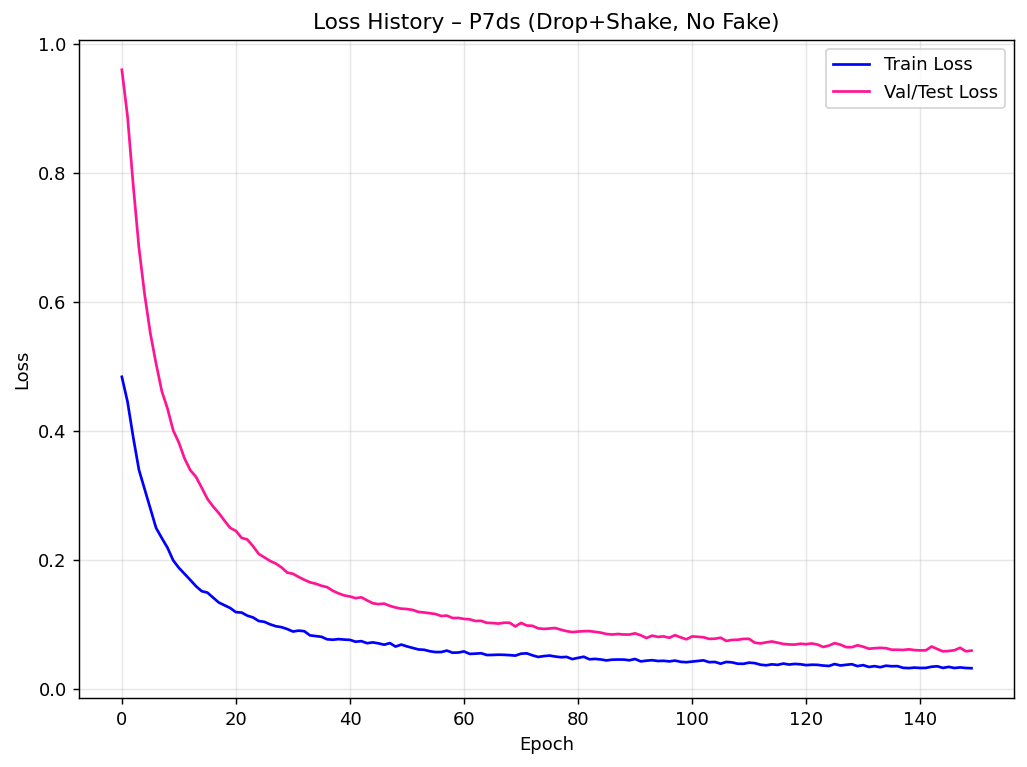

In [30]:
import pickle
import matplotlib.pyplot as plt

with open("train_history_P7ds.pkl", "rb") as f:
    train_history = pickle.load(f)
with open("test_history_P7ds.pkl", "rb") as f:
    test_history = pickle.load(f)

fig, ax = plt.subplots(figsize=(8,6), dpi=130)

ax.plot(train_history, label="Train Loss", color='blue')
ax.plot(test_history, label="Val/Test Loss", color='deeppink')
ax.set_title("Loss History – P7ds (Drop+Shake, No Fake)")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

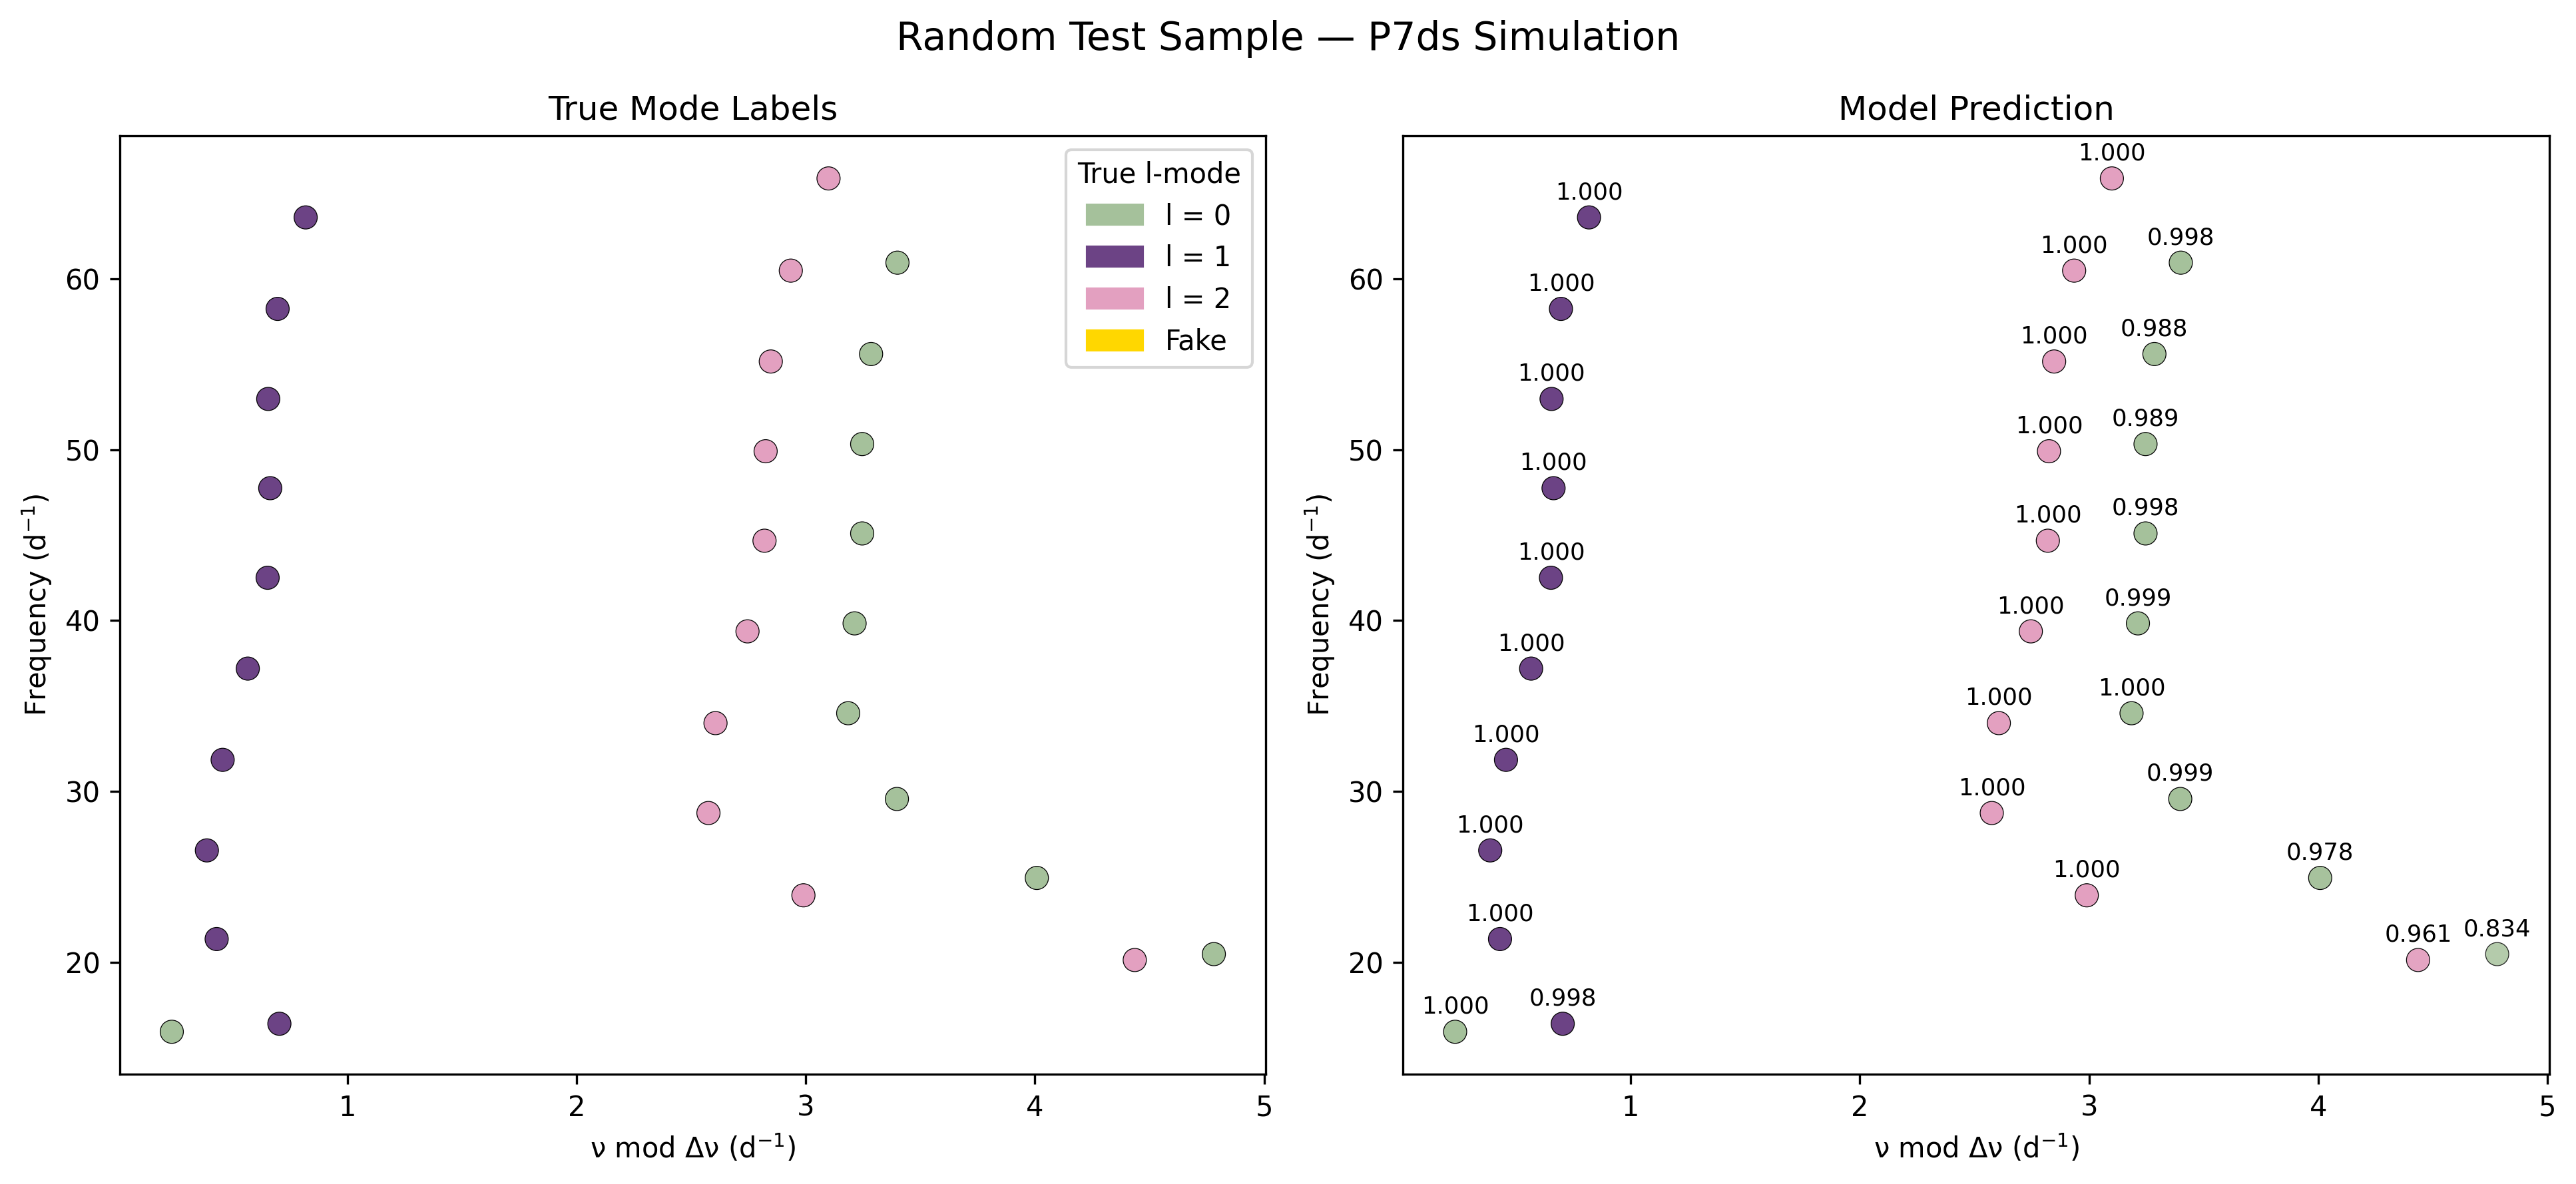

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle
import random

# --- CONFIG ---
REAL_CLASSES = [0, 1, 2]
FAKE_CLASS = 'fake'
color_map = {0: '#a5c19b', 1: '#6c4385', 2: '#e3a0c0', FAKE_CLASS: 'gold'}
marker_size = 70

# --- Load your P7ds simulation output ---
with open("output_P7ds.pkl", "rb") as f:
    output = pickle.load(f)  # shape: [num_samples, num_classes, num_points]

# --- Use your test data tensors (make sure these are already loaded) ---
# X_test, y_test should be available from your previous code and be tensors

n_models = output.shape[0]
model_idx = random.randint(0, n_models - 1)

# Pull the raw logits for this sample and convert to numpy
logits = output[model_idx].T.numpy()  # [num_points, num_classes]

freqs = X_test[model_idx, :, 1].numpy()  # mod frequencies
powers = X_test[model_idx, :, 0].numpy()  # raw frequencies
labels = y_test[model_idx, :].numpy()

# Mask invalid points
valid_mask = labels != -1
freqs = freqs[valid_mask]
powers = powers[valid_mask]
labels = labels[valid_mask]
logits = logits[valid_mask]

labels_display = np.array([l if l in REAL_CLASSES else FAKE_CLASS for l in labels], dtype=object)

# Softmax to get probabilities
logits -= np.max(logits, axis=1, keepdims=True)
probs = np.exp(logits)
probs /= probs.sum(axis=1, keepdims=True)

preds = np.argmax(probs, axis=1)
preds_display = np.array([p if p in REAL_CLASSES else FAKE_CLASS for p in preds], dtype=object)

probs_true_label = np.array([
    probs[i, l] if l in REAL_CLASSES else 0.0
    for i, l in enumerate(labels)
])

# Colors for plotting
colors_true = [color_map[l] for l in labels_display]
edge_colors_pred = [color_map[l] for l in preds_display]

# Misclassifications
wrong_mask = preds != labels
wrong_freqs = freqs[wrong_mask]
wrong_powers = powers[wrong_mask]
wrong_edge_colors = np.array(edge_colors_pred)[wrong_mask]

# --- Plot ---
fig, axs = plt.subplots(1, 2, figsize=(13, 6), dpi=300)

# LEFT: Ground truth labels
axs[0].scatter(freqs, powers, c=colors_true, edgecolors='black',
               linewidths=0.3, s=marker_size)
axs[0].set_title("True Mode Labels")
axs[0].set_xlabel("ν mod Δν (d$^{-1}$)")
axs[0].set_ylabel("Frequency (d$^{-1}$)")

legend_elements = [
    mpatches.Patch(color=color_map[0], label='l = 0'),
    mpatches.Patch(color=color_map[1], label='l = 1'),
    mpatches.Patch(color=color_map[2], label='l = 2'),
    mpatches.Patch(color=color_map[FAKE_CLASS], label='Fake')
]
axs[0].legend(handles=legend_elements, title="True l-mode", loc="upper right")

# RIGHT: Predictions
alpha_vals = np.clip(probs_true_label, 0.3, 1.0)

axs[1].scatter(freqs, powers, c=colors_true, alpha=alpha_vals,
               edgecolors='black', linewidths=0.3, s=marker_size)

axs[1].scatter(wrong_freqs, wrong_powers, facecolors='none',
               edgecolors=wrong_edge_colors, linewidths=2.0, s=marker_size + 80)

for i in range(len(freqs)):
    axs[1].text(freqs[i], powers[i] + 0.8, f"{probs_true_label[i]:.3f}",
                fontsize=8.5, ha='center', va='bottom', color='black')

axs[1].set_title("Model Prediction")
axs[1].set_xlabel("ν mod Δν (d$^{-1}$)")
axs[1].set_ylabel("Frequency (d$^{-1}$)")

fig.suptitle(f"Random Test Sample — P7ds Simulation", fontsize=14)
plt.tight_layout()
plt.show()

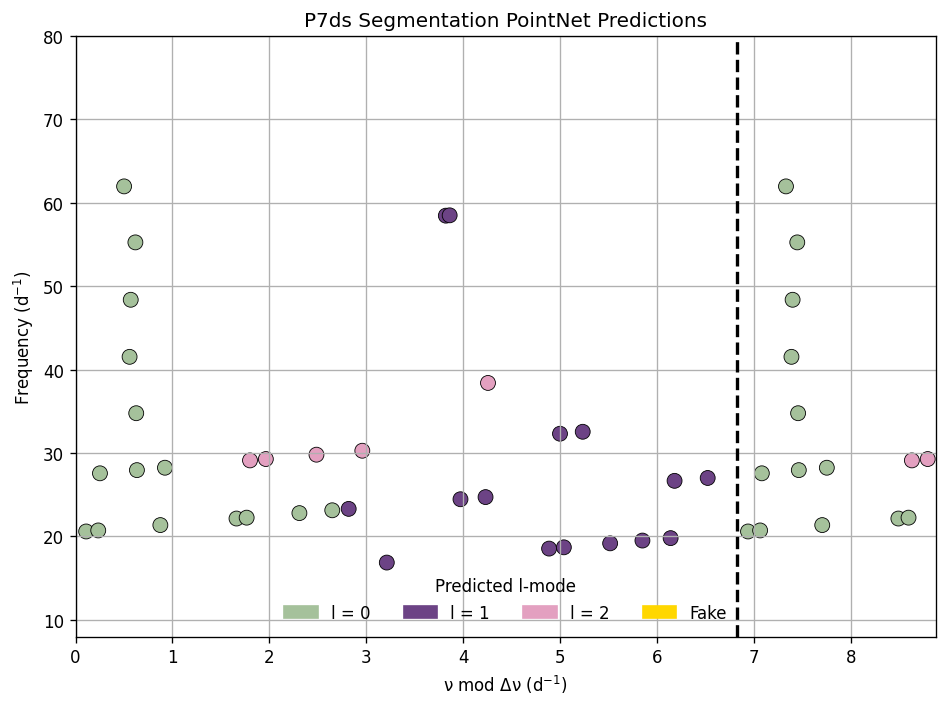

In [32]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# --- Input frequencies ---
frequencies = np.array([
    21.36513, 27.95328, 34.77609, 41.53747, 48.37933, 55.25743, 61.97086,
    16.87165, 32.55347, 38.40601, 58.46084, 28.24243, 27.01307, 20.59936,
    18.54655, 18.69868, 19.17648, 19.50970, 19.80056, 20.72404, 22.15081,
    22.25558, 22.79990, 23.13894, 23.30843, 24.46210, 24.72073, 26.67124,
    27.57177, 29.12013, 29.28361, 29.80605, 30.27912, 32.31897, 58.50036
])

#below are only the identified ones
""" 
frequencies = np.array([
    21.36513, 27.95328, 34.77609, 41.53747, 48.37933, 55.25743, 61.97086,
    26.73244, 32.55347, 38.40601, 58.46084
])
"""
delta_nu = 6.83
nu_mod_delta_nu = np.mod(frequencies, delta_nu)
X_hd = torch.tensor(np.stack([frequencies, nu_mod_delta_nu], axis=1), dtype=torch.float32).unsqueeze(0)

# --- Model definitions ---
class PointNet(torch.nn.Module):
    def __init__(self, num_classes=4, point_dimension=2, dropout=0.3):
        super(PointNet, self).__init__()
        a = 3
        nfeat = 64
        self.conv_1_a = torch.nn.Conv1d(1, nfeat, kernel_size=a, padding=1)
        self.conv_1_b = torch.nn.Conv1d(1, nfeat, kernel_size=a, padding=1)
        self.conv_2 = torch.nn.Conv1d(nfeat, nfeat, kernel_size=a)
        self.bn_1 = torch.nn.BatchNorm1d(nfeat)
        self.bn_2 = torch.nn.BatchNorm1d(nfeat)
    def forward(self, x):
        batch_size, num_points, _ = x.shape
        x_freq = x[:, :, 0].unsqueeze(1)
        x_modnu = x[:, :, 1].unsqueeze(1)
        x_freq = torch.nn.functional.pad(x_freq, (1, 1), mode='replicate')
        x_modnu = torch.nn.functional.pad(x_modnu, (1, 1), mode='circular')
        x = self.conv_1_a(x_freq) + self.conv_1_b(x_modnu)
        x = torch.nn.functional.relu(self.bn_1(x))
        x = torch.nn.functional.relu(self.bn_2(self.conv_2(x)))
        x = torch.nn.functional.max_pool1d(x, kernel_size=x.size(-1))
        return x.view(batch_size, -1)

class SegmentationPointNet(torch.nn.Module):
    def __init__(self, num_classes=4, point_dimension=2, dropout=0.3):
        super(SegmentationPointNet, self).__init__()
        self.base_pointnet = PointNet(num_classes=num_classes, point_dimension=point_dimension)
        nfeat = 64
        nhidden = 64
        self.fc_1 = torch.nn.Linear(nfeat + 2, nhidden)
        self.fc_2 = torch.nn.Linear(nhidden, num_classes)
    def forward(self, x):
        global_feat = self.base_pointnet(x).unsqueeze(1).repeat(1, x.shape[1], 1)
        x = torch.cat([x, global_feat], dim=2)
        x = torch.nn.functional.relu(self.fc_1(x))
        return torch.nn.functional.log_softmax(self.fc_2(x), dim=2)

# --- Load your P7ds segmentation model ---
model_path = "segmentation_pointnet_P7ds.pth"
model = SegmentationPointNet()
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

# --- Color setup ---
color_map = {0: '#a5c19b', 1: '#6c4385', 2: '#e3a0c0', 3: 'gold'}
legend_elements = [
    mpatches.Patch(color=color_map[0], label='l = 0'),
    mpatches.Patch(color=color_map[1], label='l = 1'),
    mpatches.Patch(color=color_map[2], label='l = 2'),
    mpatches.Patch(color=color_map[3], label='Fake')
]

# --- Inference and plotting ---
with torch.no_grad():
    logits_hd = model(X_hd)
    probs_hd = torch.exp(logits_hd)[0].numpy()  # shape: [num_points, num_classes]
    preds_hd = np.argmax(probs_hd, axis=1)

colors_pred = [color_map[int(p)] for p in preds_hd]

plt.figure(figsize=(8, 6), dpi=120)
plt.scatter(nu_mod_delta_nu, frequencies, c=colors_pred, edgecolors='black', linewidths=0.5, s=80)
plt.scatter(nu_mod_delta_nu + delta_nu, frequencies, c=colors_pred, edgecolors='black', linewidths=0.5, s=80)
plt.axvline(delta_nu, color='black', linestyle='--', linewidth=2)
plt.xlim(0, delta_nu * 1.3)
plt.ylim(8, 80)
plt.title("P7ds Segmentation PointNet Predictions")
plt.xlabel("ν mod Δν (d$^{-1}$)")
plt.ylabel("Frequency (d$^{-1}$)")
plt.grid(True)
plt.legend(handles=legend_elements, title="Predicted l-mode", loc="lower center", ncol=4, frameon=False)
plt.tight_layout()
plt.show()